# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [2]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


In [13]:
# Descriptive Stats
print "Maximums\n{}\n ".format(data.max(axis=0))
print "Minimums\n{}\n ".format(data.min(axis=0))
print "Means\n{}\n ".format(data.mean(axis=0))
print "Medians\n{}\n ".format(data.median(axis=0))
print "Unbiased variance\n{}\n ".format(data.var(axis=0))

Maximums
Fresh               112151
Milk                 73498
Grocery              92780
Frozen               60869
Detergents_Paper     40827
Delicatessen         47943
dtype: int64
 
Minimums
Fresh                3
Milk                55
Grocery              3
Frozen              25
Detergents_Paper     3
Delicatessen         3
dtype: int64
 
Means
Fresh               12000.297727
Milk                 5796.265909
Grocery              7951.277273
Frozen               3071.931818
Detergents_Paper     2881.493182
Delicatessen         1524.870455
dtype: float64
 
Medians
Fresh               8504.0
Milk                3627.0
Grocery             4755.5
Frozen              1526.0
Detergents_Paper     816.5
Delicatessen         965.5
dtype: float64
 
Unbiased variance
Fresh               1.599549e+08
Milk                5.446997e+07
Grocery             9.031010e+07
Frozen              2.356785e+07
Detergents_Paper    2.273244e+07
Delicatessen        7.952997e+06
dtype: float64
 


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:

**PCA**  
tries to maximize variance to keep the information loss small. The first dimensions for the PCs are, what has the largest range of values in the data set.  

- As the feature with the wides range (112.151 - 3 = 112.148) and the highest variance (1.599549e+08) the "Fresh" feature will be responsible for the primary part of the first PC. 
- "Grocery" as the feature with the second largest variance is most likely a part of the second PC. 
- The rest of the first PC will come from a combination of the "Milk", "Frozen", and "Detergents_Paper" feature. 
- The "Delicatessen" feature with it's little variance will play only a minor role in the PC analysis.

**ICA**  
tries to transform the feature space towards maximal independence.   
The dimensions will be distinct replenishment profiles for certain customer groups.  

- Supermarkets will have a different pattern from 'Fruits and Vegetable' stores. Supermarkets will order more 'Frozen' and 'Detergents Paper' and a little bit less 'Fresh' goods. 

- Corner stores probably order differently from 'Fine food' stories. Corner stores will order less 'Delicatessen', but more 'Grocery' goods.

source: https://www.udacity.com/course/viewer#!/c-ud727-nd/l-5453051650/m-661438547

### PCA

In [125]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA

pca = PCA(n_components = data.shape[1])
pca.fit(data)
#http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

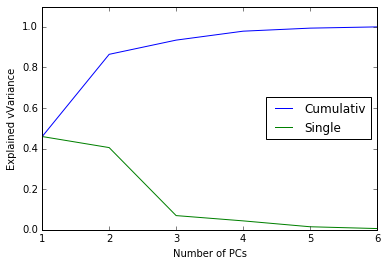

In [126]:
# PCs variance plot

cs = np.cumsum(pca.explained_variance_ratio_)
#https://github.com/numpy/numpy/blob/v1.10.0/numpy/core/fromnumeric.py#L2038-L2106
#http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.cumsum.html

# Number array for PCs
num_PCs = np.arange(data.shape[1])+1
#http://docs.scipy.org/doc/numpy-1.10.1/user/basics.creation.html

plt.plot(num_PCs, cs)
plt.plot(num_PCs, pca.explained_variance_ratio_)
#http://matplotlib.org/users/pyplot_tutorial.html

plt.axis([1, data.shape[1], 0, 1.1])
plt.xlabel('Number of PCs')
plt.ylabel('Explained vVariance')
plt.legend(['Cumulativ', 'Single'], loc='center right')
plt.show()

Answer:  

[ **0.45961362  0.40517227**  0.07003008  0.04402344  0.01502212  0.00613848]  

The first two PCs make for more than 80% of explained variance. The third PC adds 7% to explained variance. All additional PCs add less than 5% to explained variance. 
Depending on how much I want/need to reduce my data set, I would pick the first 2 to 3 PCs. In this case, with a relatively small dataset, it is reasonable to use 3 PCs. To retain as much information as possible. With larger datasets, I probably go for only 2 PCs, because it is computational cheaper/faster.

**3)** What do the dimensions seem to represent? How can you use this information?

Answer:  

These dimensions represent the directions in R<sup>6</sup> that show the most variance i.e. the largest range of values.   

[**-0.97653685** **-0.12118407** -0.06154039 **-0.15236462**  0.00705417 -0.06810471]  
*The **first dimension** of the PCA has a huge emphasis on the 'Fresh' feature and by similarity some emphasis on 'Milk' and 'Frozen'. This component captures the extent to which a customer orders **perishables** i.e. temperature controlled goods. This component has the greatest influence on customers ordering habits.*  

[-0.11061386  **0.51580216**  **0.76460638** -0.01872345  **0.36535076**  0.05707921]  
*The **second dimension** of the PCA has a huge emphasis on the 'Grocery' feature and some emphasis on 'Milk' and 'Detergents Paper'. This component captures the extent to which customer orders **fast moving consumer goods**. This component also has  a great influence on customers ordering habits.*  

[-0.17855726  0.50988675 -0.27578088  **0.71420037** -0.20440987  0.28321747]  
*The **third dimension** of the PCA has an emphasis on the 'Frozen' feature but is otherwise not as distinct as the first two dimensions.*  

### ICA

In [127]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
from sklearn import preprocessing

# feature centering
scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True).fit(data.astype(float))
data_centered = scaler.transform(data)
# http://scikit-learn.org/stable/modules/preprocessing.htmltable/auto_examples/decomposition/plot_faces_decomposition.html#example-decomposition-plot-faces-decomposition-py

ica = FastICA(n_components = data_centered.shape[1], random_state = 1)
ica.fit(data_centered).transform(data_centered)
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA

# Print the independent components
print np.around((ica.components_), decimals=3)

[[-0.004  0.017  0.114 -0.007 -0.134 -0.016]
 [ 0.05  -0.006 -0.006 -0.003  0.01  -0.003]
 [ 0.011  0.001 -0.007 -0.054  0.003  0.017]
 [-0.002 -0.073  0.055  0.002 -0.016  0.017]
 [-0.005 -0.002 -0.006 -0.003  0.002  0.051]
 [-0.003  0.014 -0.061 -0.002  0.004  0.004]]


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer:  
[-0.004  +0.017  **+0.114** -0.007 **-0.134 -0.016**]   
The first component captures customers with a high preference for the 'Grocery' and a low preferance for the 'Detergents Paper' and 'Delicatessen' features. These customers probably run discount supermarkets.  

[**+0.050**  -0.006 -0.006 -0.003  +0.010  -0.003]  
The second component captures customers with a high preference for the 'Fresh' feature. These customers probably run fruit and vegetable stores.  

[**+0.011**  +0.001 -0.007 **-0.054**  +0.003  **+0.017**]
The third component captures customers with a preference for the 'Delicatessen' and 'Fresh' and a low preferance for  'Frozen'. These customers probably run central food markets or upper-end supermarket chains.  

[-0.002 **-0.073**  **+0.055**  +0.002 **-0.016**  **+0.017**]  
The fourth component captures customers with a high preference for 'Grocery' and some preferance for 'Delicatessen' as well as no preferance for the 'Milk' and 'Detergents Paper' feature. These customers probably run kiosk-style stores like gas stations.  

[-0.005 -0.002 -0.006 -0.003  +0.002  **+0.051**]  
The fifth component captures customers with a high preference for the 'Delicatessen' feature. These customers probably run specialized 'fine food' stores like Dean and Deluca.  

[-0.003  **+0.014 -0.061** -0.002  +0.004  +0.004]   
The sixth component captures customers with a preference for the 'Milke' feature and a low preference for 'Grocery'. These customers probably run some kind of weird shop.  

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer:  

#### K-Means advantages  
- "scales well to [a] large number of samples."
- "General-purpose" clustering algorithm
- "has been used (successfully) across a large range of application areas."
- "K-Means can be seen as a special case of Gaussian mixture model with equal covariance per component."
- K-Means does hard clustering

#### Gaussian Mixture Models advantages  
- "incorporate information about the covariance structure of the data."
- "can also draw confidence ellipsoids for multivariate models."
- "compute the Bayesian Information Criterion to assess the number of clusters in the data."
- "it is the fastest algorithm for learning mixture models."
- "as this algorithm maximizes only the likelihood, it will not be bias the means towards zero, or bias the cluster sizes to have specific structures that might or might not apply."
- GMM does soft clustering

> source: http://scikit-learn.org/stable/modules/mixture.html#mixture, http://scikit-learn.org/stable/modules/clustering.html#k-means, https://www.udacity.com/course/viewer#!/c-ud727-nd/l-5455061279/m-638188663

The advantages of Gaussian  Mixture Models do not apply to this problem. Neither information about covariance is asked nor a confidence ellipsoid. Computation time is not critical more eighth. I go with K-Means as the "general-purpose" clustering algorithm.


**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [128]:
# Import clustering modules
from sklearn.cluster import KMeans
#from sklearn.cluster import MiniBatchKMeans
#from sklearn.mixture import GMM

In [129]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation

pca_2 = PCA(n_components = 2)
reduced_data = pca_2.fit(data).transform(data)
# http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#example-decomposition-plot-pca-vs-lda-py

print np.around(reduced_data)[:10]  # print upto 10 elements

[[  -650.   1586.]
 [  4427.   4042.]
 [  4842.   2579.]
 [  -990.  -6280.]
 [-10658.  -2160.]
 [  2766.   -960.]
 [   716.  -2013.]
 [  4475.   1429.]
 [  6712.  -2206.]
 [  4824.  13481.]]


In [130]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

#KMeans
clf_2 = KMeans(n_clusters = 2, init = 'k-means++', n_init = 10) #{'k-means++', 'random' or an ndarray} 
clf_3 = KMeans(n_clusters = 3, init = 'k-means++', n_init = 10)
clf_4 = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10)
clf_5 = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10)

#GMM
#clf_2 = GMM(n_components = 2, n_init = 10) 
#clf_3 = GMM(n_components = 3, n_init = 10)
#clf_4 = GMM(n_components = 4, n_init = 10)
#clf_5 = GMM(n_components = 5, n_init = 10)

# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans
# http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GMM.html#sklearn.mixture.GMM

clusters_2 = clf_2.fit(reduced_data)
clusters_3 = clf_3.fit(reduced_data)
clusters_4 = clf_4.fit(reduced_data)
clusters_5 = clf_5.fit(reduced_data)

#print clusters_2
#print clusters_3
#print clusters_4
#print clusters_5

In [131]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z_2 = clusters_2.predict(np.c_[xx.ravel(), yy.ravel()])
Z_3 = clusters_3.predict(np.c_[xx.ravel(), yy.ravel()])
Z_4 = clusters_4.predict(np.c_[xx.ravel(), yy.ravel()])
Z_5 = clusters_5.predict(np.c_[xx.ravel(), yy.ravel()])

In [132]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

# for KMeans
centroids_2 = clf_2.cluster_centers_
centroids_3 = clf_3.cluster_centers_
centroids_4 = clf_4.cluster_centers_
centroids_5 = clf_5.cluster_centers_

# for GMM
#centroids_2 = clf_2.means_
#centroids_3 = clf_3.means_
#centroids_4 = clf_4.means_
#centroids_5 = clf_5.means_

print "2 Centroids\n {}\n".format(np.around(centroids_2))
print "3 Centroids\n {}\n".format(np.around(centroids_3))
print "4 Centroids\n {}\n".format(np.around(centroids_4))
print "5 Centroids\n {}\n".format(np.around(centroids_5))

2 Centroids
 [[  4175.   -211.]
 [-24088.   1218.]]

3 Centroids
 [[  1341.  25261.]
 [-23979.  -4446.]
 [  4165.  -3105.]]

4 Centroids
 [[  5711.  12661.]
 [  3542.  -4937.]
 [-24221.  -4364.]
 [-14538.  61716.]]

5 Centroids
 [[  5559.  14313.]
 [ -9052.  -4809.]
 [  6413.  -4128.]
 [-14538.  61716.]
 [-37705.  -5488.]]



In [133]:
# Silhouette Coefficient
# source http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation

import numpy as np
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.cluster import KMeans

def Silhouette_Coefficient (clf, X):
    labels = clf.labels_
    print "Silhouette Coefficient {:.3f}".format(metrics.silhouette_score(X, labels, metric='euclidean'))

Silhouette_Coefficient (clf_2, reduced_data)
Silhouette_Coefficient (clf_3, reduced_data)
Silhouette_Coefficient (clf_4, reduced_data)
Silhouette_Coefficient (clf_5, reduced_data)

Silhouette Coefficient 0.543
Silhouette Coefficient 0.523
Silhouette Coefficient 0.462
Silhouette Coefficient 0.452


#### Silhouette analysis

While the ground truth lables are not known the evaluation of the KMeans clustering is limited. 
The Silhouette analysis shows silhouette coefficients that are not very high. They are dropping with an increase of the cluster count. The Silhouette analysis suggests a low number of clusters for this data set.

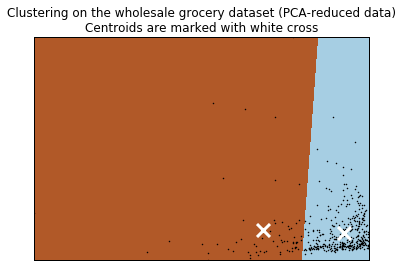

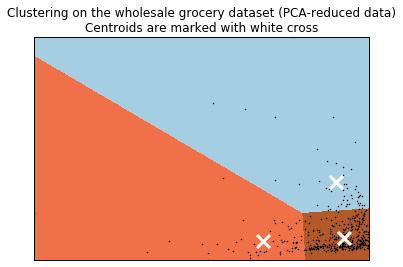

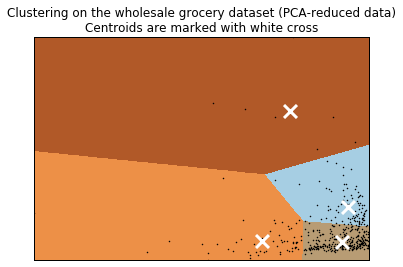

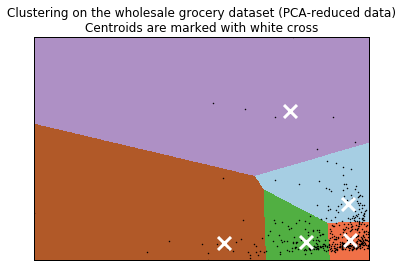

In [134]:
# Put the result into a color plot

def PCA_plot(Z, centroids):
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap=plt.cm.Paired,
            aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
             color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
        'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    plt.show()

PCA_plot(Z_2, centroids_2)
PCA_plot(Z_3, centroids_3)
PCA_plot(Z_4, centroids_4)
PCA_plot(Z_5, centroids_5)

Having only two components to describe the clusters and considering the distribution of the customers in the plot, it makes not much sense to go beyond four clusters. The main difference between the four cluster plot and the three cluster plot is that the two (not very distinct) upper clusters are "merged". For a two cluster analysis, one component would be sufficient.  
Given that we saw that the first two components beeing relevant to the analysis. And the fact that a fourth cluster does not add significance to the plot. Three clusters seem to be the best choice for this data set.

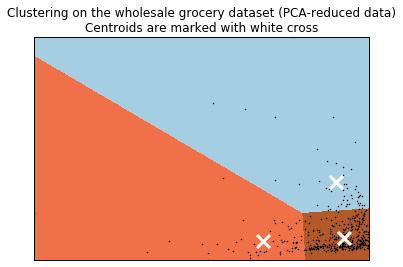

Shop Profiles
 [[  7896.  18664.  27184.   2395.  12120.   2875.]
 [ 35908.   6409.   6028.   6809.   1088.   2904.]
 [  8276.   3690.   5321.   2495.   1776.   1064.]]



In [135]:
# Sampling
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mean.html?highlight=mean

#cluster_shops = np.dot(centroids_3, pca_2.components_[:2]) 
#Thanks Mitchell

#mean = data.mean(axis=0).values 

#print (cluster_shops)
#print (mean)

shop_profiles = np.dot(centroids_3, pca_2.components_[:2]) + data.mean(axis=0).values 

PCA_plot(Z_3, centroids_3)
print "Shop Profiles\n {}\n".format(np.around(shop_profiles))



**7)** What are the central objects in each cluster? Describe them as customers.

Answer:  

**upper cluster**:  
[07866, **18810**, **27401**, 02389, **12224**, 02891]  
Customers that mostly order fast moving consumer goods in huge quantities. Like large supermarkets.   

**lower-left cluster**:  
[**35908**, 06409, 06027, 06808, 01088, 02904]  
Customers that mostly order perishable goods. Like fruit and vegetable outlets or central market.  

**lower-right cluster**:  
[08322, 03708, 05342, 02502, 01784, 01068]  
Customers that order perishable and fast moving consumer goods in lower quantities. Like small corner stores and kiosks.

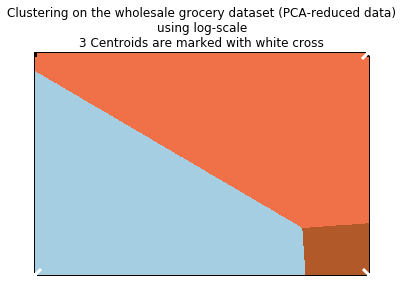

In [136]:
# Log transform

#from sklearn.preprocessing import FunctionTransformer
#FunctionTransformer throughs an ImportError: cannot import name FunctionTransformer

# Transformer
#transformer = sklearn.preprocessing.FunctionTransformer(np.log1p)
data_33 = data
#transformer.transform(data_33)

# PCA
pca3 = PCA(n_components = 2)
reduced_data_33 = pca3.fit(data_33).transform(data_33)

# Clusters
clf_33 = KMeans(n_clusters = 3, init = 'k-means++', n_init = 10)
clusters_33 = clf_33.fit(reduced_data)
#print clusters_33

# Grid
x_min, x_max = reduced_data_33[:, 0].min() - 1, reduced_data_33[:, 0].max() + 1
y_min, y_max = reduced_data_33[:, 1].min() - 1, reduced_data_33[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

#
Z_33 = clusters_33.predict(np.c_[xx.ravel(), yy.ravel()])

#
#centroids_33 = clf_33.cluster_centers_
#print centroids_33

#

Z = Z_33.reshape(xx.shape)
plt.figure(2)
plt.clf()
plt.imshow(Z, interpolation='nearest',
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            cmap=plt.cm.Paired,
            aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids_3[:, 0], centroids_3[:, 1],
            marker='x', s=169, linewidths=3,
             color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'using log-scale\n'
          '3 Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xscale('log') #sub2 addition
plt.yscale('log') #sub2 addition
plt.xticks(())
plt.yticks(())
plt.show()

In [137]:
#Using PC 2 and 3 for more insight
pca3 = PCA(n_components = 3)
reduced_data_22 = pca3.fit(data).transform(data)
reduced_data_22 = reduced_data_22[:,1:3]

In [138]:
# The visualizer below assumes your clustering object is named 'clusters'

clf_22 = KMeans(n_clusters = 3, init = 'k-means++', n_init = 10) #{'k-means++', 'random' or an ndarray}

# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans
# http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GMM.html#sklearn.mixture.GMM

clusters_22 = clf_22.fit(reduced_data_22)

print clusters_22

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


In [139]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min_2, x_max_2 = reduced_data_22[:, 0].min() - 1, reduced_data_22[:, 0].max() + 1
y_min_2, y_max_2 = reduced_data_22[:, 1].min() - 1, reduced_data_22[:, 1].max() + 1
hx_2 = (x_max_2-x_min_2)/1000.
hy_2 = (y_max_2-y_min_2)/1000.
xx_2, yy_2 = np.meshgrid(np.arange(x_min_2, x_max_2, hx_2), np.arange(y_min_2, y_max_2, hy_2))

# Obtain labels for each point in mesh. Use last trained model.
Z_22 = clusters_22.predict(np.c_[xx_2.ravel(), yy_2.ravel()])

In [140]:
# for KMeans
centroids_22 = clf_22.cluster_centers_

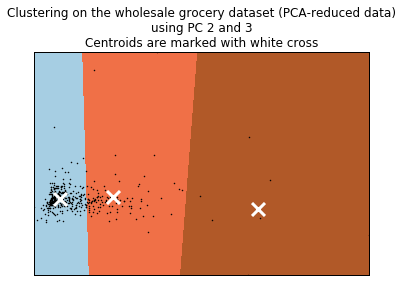

In [141]:
# Put the result into a color plot
Z_22 = Z_22.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z_22, interpolation='nearest',
           extent=(xx_2.min(), xx_2.max(), yy_2.min(), yy_2.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data_22[:, 0], reduced_data_22[:, 1], 'k.', markersize=2)
plt.scatter(centroids_22[:, 0], centroids_22[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'using PC 2 and 3\n'
          'Centroids are marked with white cross')
plt.xlim(x_min_2, x_max_2)
plt.ylim(y_min_2, y_max_2)
plt.xticks(())
plt.yticks(())
plt.show()

The plot of PC two and three looks very symmetric (except for some outliers).
It does not add much information concerning the clustering.
It is the same clusters dragged out into another dimension. No interesting splits to see. All centroids almost on one line.
Besides, it is hard to find a description for the third dimension. It is not clear which information is contained in there.

Neither a logarithmic scale nor the third component can add more inside into the clustering.

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer:  

I've got the most insight into the data by the 2D scatter plot of the reduced customer data into the space of the first two PC. It helps to get an intuition how the customers are distributed. Where potential clusters are. And what kind of profiles the customers, in an individual cluster, will have. This intuition is very useful in proceeding with a more detailed analysis of the data and the clusters. 

**9)** How would you use that technique to help the company design new experiments?

Answer:  

Some techniques to design new experiments after the PCA clustering are:  

- First of all, you should make a **validity check** against third party data, if the results of your PCA are reasonable.  

- It might make sense to accumulate more data about the customers in each cluster by running a **survey, focus groups or a UER** (user experience research) to understand their needs beyond the PCs.  

- Use this data to do **A/A testing** inside each cluster to gather information about the variability inside the clusters. This helps to determine a robust baseline for the A/B tests.  

- **Intra-cluster A/B testing** (test and control group from the same cluster) for testing new cluster specific products and services. Eg. disposal services for customers from the perishable cluster or VMI (vendor managed inventory) for the FMCG (fast moving consumer goods) cluster customers.   

- **Inter-cluster A/B testing** (test and control group from different clusters) for testing new general (unspecific) products and services. Eg. offering replenishment by urban freight distribution providers.  

- Make sure that your test and control group for these experiments are not secured by checking the included customers for features like company size, order size, and location.


**10)** How would you use that data to help you predict future customer needs?

Answer:   

You can make better predictions if you put a new customer into the designated cluster first and make your predictions from there. Instead of predicting from the whole set of customers i.e. the average customer.  
This information can be used for cross- and upselling offers as well as bulk discounts, depending on the cluster.
Sells people can use this data to see if a certain customer has weak sells in a certain category, compared with the other "reference customers" in the cluster. They might be able to identify opportunities for new offers to these customers.  
Another interesting experiment would be to track the developments over time. For single customers and the whole set. Maybe there is a customer-life-cycle, where they move through different clusters over time. It might be possible to make and algorithm that could learn this pattern and make predictions, how a new customer might evolve.  